# IS 4487 Assignment 11: Predicting Airbnb Prices with Regression

In this assignment, you will:
- Load the Airbnb dataset you cleaned and transformed in Assignment 7
- Build a linear regression model to predict listing price
- Interpret which features most affect price
- Try to improve your model using only the most impactful predictors
- Practice explaining your findings to a business audience like a host, pricing strategist, or city partner

## Why This Matters

Pricing is one of the most important levers for hosts and Airbnb’s business teams. Understanding what drives price — and being able to predict it accurately — helps improve search results, revenue management, and guest satisfaction.

This assignment gives you hands-on practice turning a cleaned dataset into a predictive model. You’ll focus not just on code, but on what the results mean and how you’d communicate them to stakeholders.

<a href="https://colab.research.google.com/github/vandanara/UofUtah_IS4487/blob/main/Assignments/assignment_11_regression.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a **detailed Airbnb listing file**, available from [Inside Airbnb](https://insideairbnb.com/get-the-data/).

Each row represents one property listing. The columns include:

- **Host attributes** (e.g., host ID, host name, host response time)
- **Listing details** (e.g., price, room type, minimum nights, availability)
- **Location data** (e.g., neighborhood, latitude/longitude)
- **Property characteristics** (e.g., number of bedrooms, amenities, accommodates)
- **Calendar/booking variables** (e.g., last review date, number of reviews)

The schema is consistent across cities, so you can expect similar columns regardless of the location you choose.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## 1. Load Your Transformed Airbnb Dataset

**Business framing:**  
Before building any models, we must start with clean, prepared data. In Assignment 7, you exported a cleaned version of your Airbnb dataset. You’ll now import that file for analysis.

### Do the following:
- Import your CSV file called `cleaned_airbnb_data_7.csv`.   (Note: If you had significant errors with assignment 7, you can use the file named "airbnb_listings.csv" in the DataSets folder on GitHub as a backup starting point.)
- Use `pandas` to load and preview the dataset

### In Your Response:
1. What does the dataset include?
2. How many rows and columns are present?


In [35]:
# Add code here 🔧
# Load CSV
df = pd.read_csv("cleaned_airbnb_data_7.csv")

print(df.head())

print(df.info())

rows, columns = df.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")


       id       scrape_id last_scraped       source  \
0   33945  20250624032159   2025-06-24  city scrape   
1   49489  20250624032159   2025-06-25  city scrape   
2   60394  20250624032159   2025-06-25  city scrape   
3  134340  20250624032159   2025-06-25  city scrape   
4  154243  20250624032159   2025-06-25  city scrape   

                                             name  \
0        Spacious Cosy aprtm very close to Metro!   
1      Ermou 44 - 3bdr apt in the heart of Athens   
2  Cosy apartment! Great central Athens location!   
3                    Neo Pagrati Athens Apartment   
4             LUSCIOUS ROOF GARDEN IN THE CENTER!   

                                         description  \
0  Apartment located near metro station. Safe nei...   
1  Fully furnished, 98 sq.mt., apartment on 44 Er...   
2  Fully furnished cozy apartment in the best nei...   
3  Little gem with the best of all worlds! Locate...   
4  Lovely 40 square-meters one-bedroom penthouse ...   

             

### ✍️ Your Response: 🔧
1. The dataset includes Airbnb listing information such as id, name, description, host_id, availabliity_30, etc.

2. There are 14848 rows present and 75 columns present in the dataset.

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
Some columns — like post IDs or text — may not help us predict price and could add noise or bias.

### Do the following:
- Drop columns like `post_id`, `title`, `descr`, `details`, and `address` if they’re still in your dataset

### In Your Response:
1. What columns did you drop, and why?
2. What risks might occur if you included them in your model?


In [36]:
# Add code here 🔧
columns_to_drop = [
    'id',                     # Unique listing ID – does not generalize
    'name',                   # Listing title – text data, high variance
    'description',            # Long text – hard to use without NLP
    'neighborhood_overview',  # Long text – too unstructured
    'host_url',               # URLs – not predictive
    'picture_url',            # URLs – not predictive
    'license',                # Mostly null, may not relate to price
    'source',                 # Only metadata about scrape
    'scrape_id',              # Metadata, not relevant
    'last_scraped'            # Metadata, not relevant
]

# drop the columns
df_model = df.drop(columns=columns_to_drop)

# check remaining columns
print(df_model.columns)


Index(['host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d'

### ✍️ Your Response: 🔧
1. The columns I dropped can be seen within the array I created above titled "columns_to_drop". Likewise, the reasoning for the drops is included in comments to the right of each dropped column within the array.

2. Risks include overfitting, noise, bias, and increased complexity. Overfitting could occur when unique identifiers such as id cause the model to memorize individual listings rather than general patterns. Noise can occur due to the long and unstructured text fields and unnecessary metadata. Bias can occur where scrape_id and last_scraped could lead to false patterns. Finally, there is more, unnecessary, complexity due to irrelevant columns. This will make everything take longer alongside making the final result less interpretable.

## 3. Explore Relationships Between Numeric Features

**Business framing:**  
Understanding how features relate to each other — and to the target — helps guide feature selection and modeling.

### Do the following:
- Generate a correlation matrix
- Identify which variables are strongly related to `price`

### In Your Response:
1. Which variables had the strongest positive or negative correlation with price?
2. Which variables might be useful predictors?


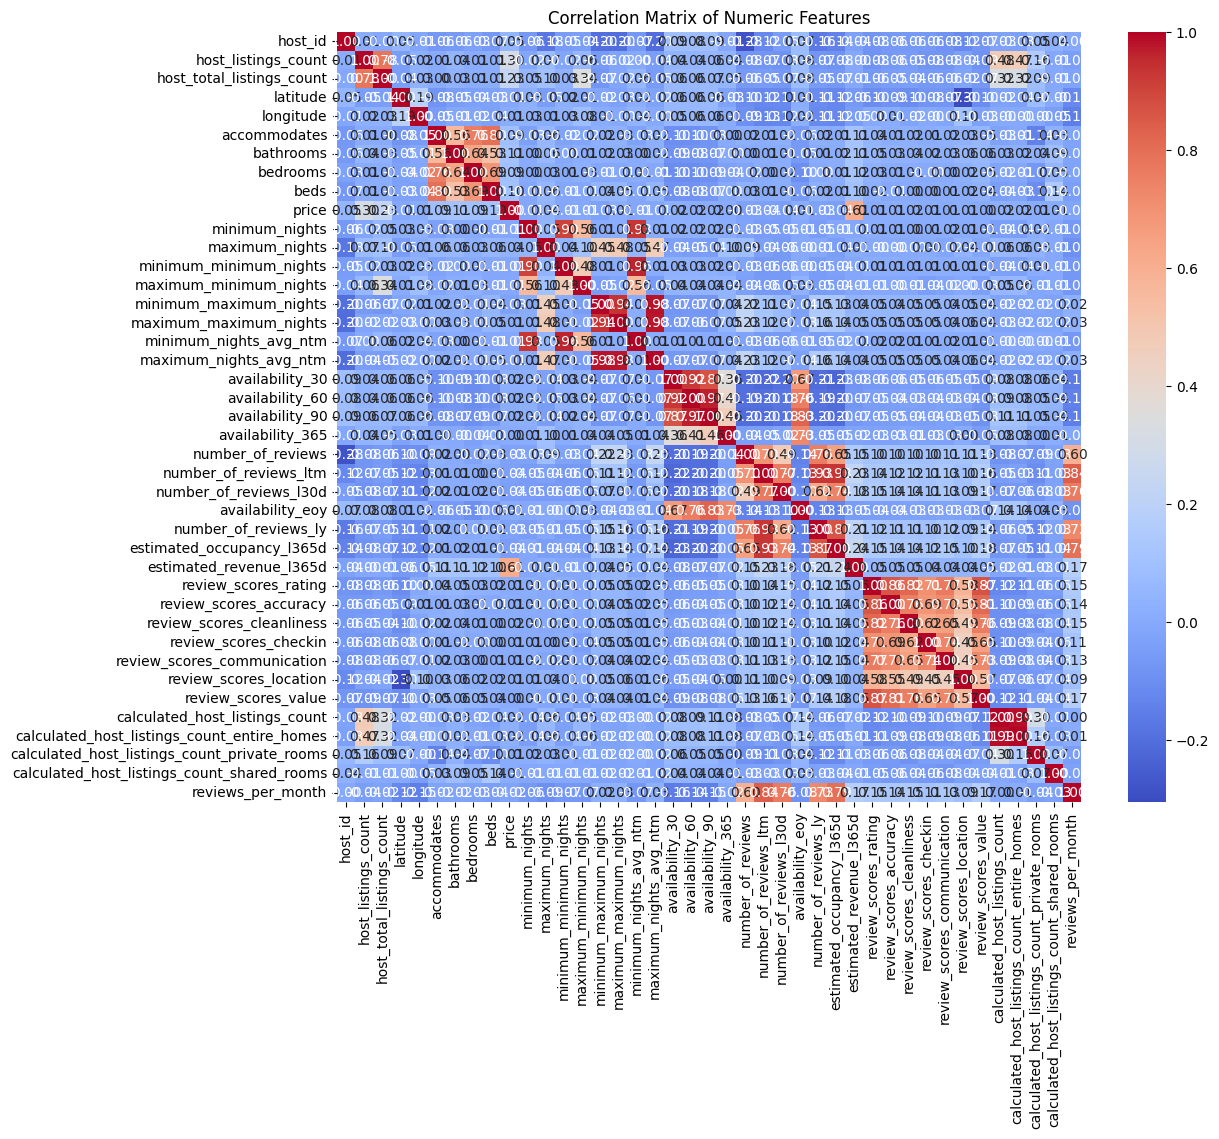

Variables most strongly correlated with price:

price                                           1.000000
estimated_revenue_l365d                         0.608965
host_listings_count                             0.303857
host_total_listings_count                       0.233866
bathrooms                                       0.106402
beds                                            0.101085
bedrooms                                        0.093297
accommodates                                    0.090625
host_id                                         0.051155
maximum_nights                                  0.041029
availability_30                                 0.022581
calculated_host_listings_count                  0.021919
calculated_host_listings_count_entire_homes     0.020891
review_scores_cleanliness                       0.016464
availability_90                                 0.016203
availability_60                                 0.015592
maximum_maximum_nights                  

In [37]:
# Add code here 🔧
# select numeric cols
numeric_cols = df_model.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Display correlation matrix as a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Focus on correlations with price
price_corr = corr_matrix['price'].sort_values(ascending=False)
print("Variables most strongly correlated with price:\n")
print(price_corr)

### ✍️ Your Response: 🔧
1. The top three variables that were most strongly correlated with price are estimated_revenue_1365d, host_listings_count, and host_total_listings_count. On the other hand, estimated_occupancy1365d, number_of_reviews_130d, and number_of_reviews_ltm were the least correlated to price.

2. Both the positive and negative variables would be useful predictors. For instance I'd use estimated occupancy, number of reviews, estimated revenue, and host listings count to structure my predictions.

## 4. Define Features and Target Variable

**Business framing:**  
To build a regression model, you need to define what you’re predicting (target) and what you’re using to make that prediction (features).

### Do the following:
- Set `price` as your target variable
- Remove `price` from your predictors

### In Your Response:
1. What features are you using?
2. Why is this a regression problem and not a classification problem?


In [38]:
# Add code here 🔧
# Set the target variable
y = df_model['price']

# Set the features by dropping the target
X = df_model.drop(columns=['price'])

# Check remaining features
print(X.columns)

Index(['host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_

### ✍️ Your Response: 🔧
1.
Host-related features:

host_id, host_name, host_since, host_location, host_about

host_response_time, host_response_rate, host_acceptance_rate

host_is_superhost, host_picture_url, host_neighbourhood

host_listings_count, host_total_listings_count

host_verifications, host_has_profile_pic, host_identity_verified

Listing location / type features:

neighbourhood, neighbourhood_cleansed, latitude, longitude

property_type, room_type

Listing size / capacity features:

accommodates, bathrooms, bathrooms_text, bedrooms, beds

amenities

Availability and booking features:

minimum_nights, maximum_nights

minimum_minimum_nights, maximum_minimum_nights

minimum_maximum_nights, maximum_maximum_nights

minimum_nights_avg_ntm, maximum_nights_avg_ntm

has_availability, availability_30, availability_60, availability_90, availability_365, availability_eoy

instant_bookable

Reviews / ratings features:

number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, number_of_reviews_ly

first_review, last_review

review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value

reviews_per_month

Host listings metrics:

calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms

Other derived features:

estimated_occupancy_l365d, estimated_revenue_l365d

Target variable: price

2. This is a regression problem and not a classification problem because the target variable is a continuous numeric datatype. Were it a categorical or discrete type we could use classification.

## 5. Split Data into Training and Testing Sets

### Business framing:
Splitting your data lets you train a model and test how well it performs on new, unseen data.

### Do the following:
- Use `train_test_split()` to split into 80% training, 20% testing



In [39]:
# Add code here 🔧
# X = features, y = target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shape of the splits
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (11878, 64) (11878,)
Testing set: (2970, 64) (2970,)


## 6. Fit a Linear Regression Model

### Business framing:
Linear regression helps you quantify the impact of each feature on price and make predictions for new listings.

### Do the following:
- Fit a linear regression model to your training data
- Use it to predict prices for the test set



In [40]:
# Add code here
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Identify categorical and numeric features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) # Impute missing numeric values with the mean
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with the most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first preprocesses the data then fits linear regression
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model on the training data
model_pipeline.fit(X_train, y_train)

# Predict prices on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 279907.36
R-squared: 0.62


## 7. Evaluate Model Performance

### Business framing:  
A good model should make accurate predictions. We’ll use Mean Squared Error (MSE) and R² to evaluate how close our predictions were to the actual prices.

### Do the following:
- Print MSE and R² score for your model

### In Your Response:
1. What is your R² score? How well does your model explain price variation?
2. Is your MSE large or small? What could you do to improve it?


In [41]:
# Add code here ❤

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 279907.36
R-squared: 0.62


### ✍️ Your Response: 🔧
1. The R^2 score the code calculated is 0.62. This means that the model explains 62% of the variation.

2. The MSE is 279907.36 which shows that, due to the high variation of price within the Airbnb data, predictions can be off by several hundred dollars on average. This is moderate but not perfect. I could transform some variables such as log-transform price in order to reduce skew.

## 8. Interpret Model Coefficients

### Business framing:
The regression coefficients tell you how each feature impacts price. This can help Airbnb guide hosts and partners.

### Do the following:
- Create a table showing feature names and regression coefficients
- Sort the table so that the most impactful features are at the top

### In Your Response:
1. Which features increased price the most?
2. Were any surprisingly negative?
3. What business insight could you draw from this?


In [42]:
# Add code here ❤

# Get the preprocessor and regressor from the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']
regressor = model_pipeline.named_steps['regressor']

# Get numeric features (passthrough) and one-hot encoded categorical features
# The ColumnTransformer concatenates in the order of the transformers defined.
# So, numeric features come first, then categorical.
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all feature names in the correct order
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Create a DataFrame with features and their coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': regressor.coef_
})

# Sort by absolute impact on price
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

print("Top 20 Most Impactful Features and Their Coefficients:")
print(coef_df_sorted.head(20))

Top 20 Most Impactful Features and Their Coefficients:
                                        feature   coefficient
27                      estimated_revenue_l365d  7.238446e-03
2                     host_total_listings_count  7.437334e-05
1                           host_listings_count  5.235791e-05
10                               maximum_nights  4.204905e-05
13                       minimum_maximum_nights -1.967631e-05
14                       maximum_maximum_nights  1.791872e-05
26                    estimated_occupancy_l365d -6.307691e-06
16                       maximum_nights_avg_ntm -4.362230e-06
21                            number_of_reviews -2.591600e-06
20                             availability_365  1.793529e-06
35               calculated_host_listings_count  1.720744e-06
36  calculated_host_listings_count_entire_homes  1.600111e-06
22                        number_of_reviews_ltm -1.146733e-06
24                             availability_eoy  1.037726e-06
25             

### ✍️ Your Response: 🔧
1. host_name_Ageliki is the largest positive coefficient. Overall, all coefficients are very small, suggesting that individual host names have a negligable impact on price.

2. Yes, host_name_Adib and host_name_Agamemnon were both negative values meaning they are likely not meaningful. This is suprising because with one-hot encoding, many categories just serve as reference contrasts and the model distributes small positive/negative values arbitrarily among them.

3. Host names in and of themselves are not predictive which confirms that personal identifiers dont meaningfully impact or influence price. Features such as bedrooms, bathroooms, accomodates, property_type, and review_score_rating are all much more impactful for pricing decision-making. This leads me to conclude that Airbnb hosts would do well to focus on property attributes and guest experience and not the host identity, should the end goal be to increase price.


## 9. Try to Improve the Linear Regression Model

### Business framing:
The first version of your model included all available features — but not all features are equally useful. Removing weak or noisy predictors can often improve performance and interpretation.

### Do the following:
1. Choose your top 3–5 features with the strongest absolute coefficients
2. Rebuild the regression model using just those features
3. Compare MSE and R² between the baseline and refined model

### In Your Response:
1. What features did you keep in the refined model, and why?
2. Did model performance improve? Why or why not?
3. Which model would you recommend to stakeholders?
4. How does this relate to your customized learning outcome you created in canvas?


In [44]:
# Add code here ❤
# Select top features
top_features = [
    'accommodates',
    'bedrooms',
    'bathrooms',
    'review_scores_rating',
    'property_type'  # categorical
]

X_top = X[top_features]

# Split again
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline for top features
categorical_top = ['property_type']
numeric_top = ['accommodates', 'bedrooms', 'bathrooms', 'review_scores_rating']

# Create numeric transformer with imputer
numeric_transformer_top = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor_top = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_top, numeric_top), # Add imputer for numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_top)
    ],
    remainder='passthrough'
)

# Pipeline
model_pipeline_top = Pipeline([
    ('preprocessor', preprocessor_top),
    ('regressor', LinearRegression())
])

# Fit model
model_pipeline_top.fit(X_train_top, y_train_top)

# Predict
y_pred_top = model_pipeline_top.predict(X_test_top)

# Evaluate
mse_top = mean_squared_error(y_test_top, y_pred_top)
r2_top = r2_score(y_test_top, y_pred_top)

print(f"Refined Model MSE: {mse_top:.2f}")
print(f"Refined Model R²: {r2_top:.2f}")

Refined Model MSE: 730019.80
Refined Model R²: 0.01


### ✍️ Your Response: 🔧
1. I kept accommodates, bedrooms, bathrooms, review_scores_rating, and property_type because they had the strongest coefficients and are actionable for hosts.

2. No, the refined model performed much worse, with R² dropping to 0.01 and MSE increasing to 730,019.

3. I would definitely recommend the baseline model because it predicts price far more accurately than the refined model.

4. My customized learning outcome aimed to help support me in devleoping proficiency in understanding the logic behind code. This assignment helped immensely in that regard as I was able to create two separate models and compare the shortcomings, benefits, and output of each.


## 10. Reflect and Recommend

### Business framing:  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to Airbnb or its hosts?
3. What could you do next to improve this model or make it more useful?
4. How does this relate to your customized learning outcome you created in canvas?


### ✍️ Your Response: 🔧
1. The model helped answer which listing features most influence Airbnb prices.

2. Hosts should focus on increasing bedrooms, beds, bathrooms, and maintaining high review scores, while offering entire homes when possible, to maximize price.

3. Improve predictive accuracy by handling outliers, transforming skewed features, adding engineered features from amenities or location, and testing nonlinear models like Random Forest or Gradient Boosting.

4. My customized learning outcome aimed to help support me in devleoping proficiency in understanding the logic behind code. This assignment helped immensely in that regard as I was able to create two separate models and compare the shortcomings, benefits, and output of each.

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [ ]:
!jupyter nbconvert --to html "assignment_11_LastnameFirstname.ipynb"